In [ ]:
class Value:
  def __init__(self, data, _children=(), _op='', label = ''):
    self.data =  data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = _children
    self._op = _op
    self.label = label
  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data + other.data, (self,other), '+')
      def _backward():
        self.grad = 1.0 * out.grad
        other.grad = 1.0 * out.grad
      out._backward = _backward
      return out

  def __mul__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data * other.data, (self,other), '*')
      def _backward():
        self.grad = other.data * out.grad
        other.grad = self.data * out.grad
      out._backward = _backward
      return out


  def __rmul__(self, other):
    return self * other

  def __pow__(self,other):
    assert isinstance(other, (int, float))
    out = Value(self.data ** other, (self, ), f'**{other}')
    def _backward():
      self.grad = other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward


  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
      self.grad = out.data * out.grad
    out._backward = _backward
    return out

  def __trudiv__(self,other):
    return self * other ** -1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [ ]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }"% (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot

In [ ]:
import math

In [ ]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88)

x1w1 = x1*w1
x1w1.label = 'x1w1'

x2w2 = x2*w2
x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()

o.label = 'o'


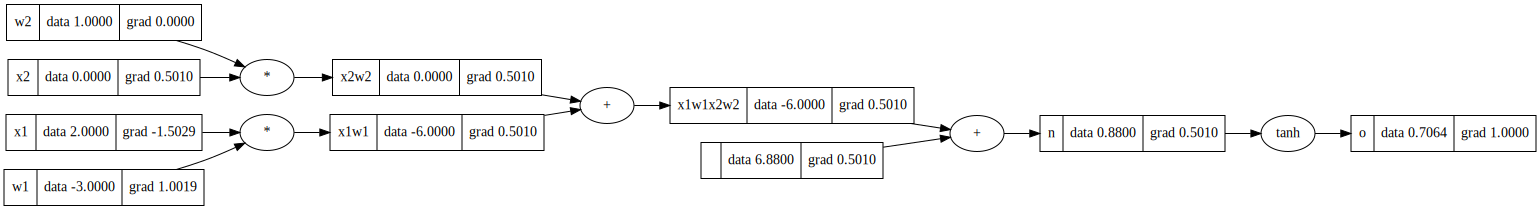

In [ ]:
draw_dot(o)

In [ ]:
o.grad = 1.0

In [ ]:
o.backward()

In [ ]:
a = Value(2.0)
2 * a
